In [21]:
!pip uninstall -y cuml-cu12 dask-cudf-cu12 cudf-cu12
!pip install -U scikit-learn


Found existing installation: cuml-cu12 25.6.0
Uninstalling cuml-cu12-25.6.0:
  Successfully uninstalled cuml-cu12-25.6.0
Found existing installation: dask-cudf-cu12 25.6.0
Uninstalling dask-cudf-cu12-25.6.0:
  Successfully uninstalled dask-cudf-cu12-25.6.0
Found existing installation: cudf-cu12 25.6.0
Uninstalling cudf-cu12-25.6.0:
  Successfully uninstalled cudf-cu12-25.6.0
  Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.4.2
    Uninstalling scikit-learn-1.4.2:
      Successfully uninstalled scikit-learn-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you

In [1]:
!pip install -U scikit-learn pandas joblib datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pa

In [2]:
import sklearn, pandas, joblib, datasets

print("scikit-learn:", sklearn.__version__)
print("pandas:", pandas.__version__)
print("joblib:", joblib.__version__)
print("datasets:", datasets.__version__)


scikit-learn: 1.7.1
pandas: 2.3.1
joblib: 1.5.1
datasets: 4.0.0


In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
import joblib

In [11]:
# 1. Data Load from Hugging Face
url = "https://huggingface.co/datasets/aai510-group1/telco-customer-churn/resolve/main/train.csv"
df = pd.read_csv(url)


In [12]:
# 2. Features / Target split
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [68]:
# 4. Preprocessing
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [69]:
# 5. Base pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression())
])

In [70]:

# 6. Parameter grid (list of dicts for both models)
param_grid = [
    {
        "classifier": [LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)],
        "classifier__C": [0.1, 1.0, 10],
        "classifier__penalty": ["l2"]
    },
    {
        "classifier": [RandomForestClassifier(class_weight="balanced", random_state=42)],
        "classifier__n_estimators": [100, 300],
        "classifier__max_depth": [None, 10, 20]
    }
]

In [71]:
# 7. GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring="roc_auc", n_jobs=-1, verbose=2)


In [72]:
# 8. Fit
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,estimator,Pipeline(step...egression())])
,param_grid,"[{'classifier': [LogisticRegre...ndom_state=42)], 'classifier__C': [0.1, 1.0, ...], 'classifier__penalty': ['l2']}, {'classifier': [RandomForestC...ndom_state=42)], 'classifier__max_depth': [None, 10, ...], 'classifier__n_estimators': [100, 300]}]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [73]:
# 9. Best pipeline
best_pipe = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'classifier': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42), 'classifier__C': 0.1, 'classifier__penalty': 'l2'}


In [74]:
# 10. Evaluation
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

In [76]:
print("\nROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       621
           1       1.00      1.00      1.00       224

    accuracy                           1.00       845
   macro avg       1.00      1.00      1.00       845
weighted avg       1.00      1.00      1.00       845



In [77]:
# 11. Confusion Matrix (numbers)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[621   0]
 [  0 224]]


In [79]:
# 13. Save model
joblib.dump(best_pipe, "telco_churn_pipeline.joblib")
print("\nModel saved as telco_churn_pipeline.joblib")



Model saved as telco_churn_pipeline.joblib


In [80]:
# 14. Reload test
loaded_model = joblib.load("telco_churn_pipeline.joblib")
sample = X_test.iloc[[0]]
print("\nSample prediction:", loaded_model.predict(sample))
print("Sample probability:", loaded_model.predict_proba(sample))


Sample prediction: [0]
Sample probability: [[9.99134386e-01 8.65614435e-04]]


In [82]:
# Metrics summary table
metrics_summary = pd.DataFrame({
    "Accuracy": [accuracy_score(y_test, y_pred)],
    "Precision": [precision_score(y_test, y_pred)],
    "Recall": [recall_score(y_test, y_pred)],
    "F1 Score": [f1_score(y_test, y_pred)],
    "ROC-AUC": [roc_auc_score(y_test, y_proba)]
})

print("📊 Metrics Summary Table:")
print(metrics_summary.to_string(index=False))

📊 Metrics Summary Table:
 Accuracy  Precision  Recall  F1 Score  ROC-AUC
      1.0        1.0     1.0       1.0      1.0


In [83]:
# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred))


📄 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       621
           1       1.00      1.00      1.00       224

    accuracy                           1.00       845
   macro avg       1.00      1.00      1.00       845
weighted avg       1.00      1.00      1.00       845



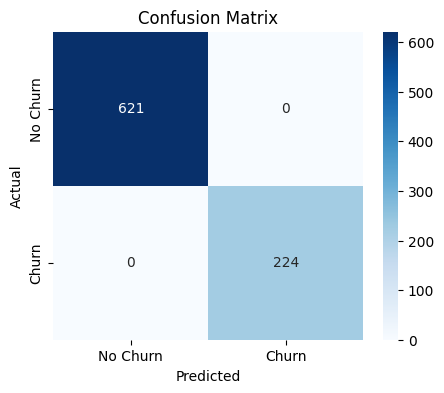

In [84]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()